<a href="https://www.kaggle.com/code/dlbkvv/exam-ships-segmentation?scriptVersionId=178607232" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [255]:
!pip install -q segmentation-models-pytorch

In [256]:
!pip install -q torchsummary

In [257]:
import numpy as np 
import pandas as pd 
import torch
import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torchsummary import summary
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch import DeepLabV3Plus
import torchmetrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [258]:
df = pd.read_csv('/kaggle/input/itstep-exam2/ship_segmentations.csv')
img_dir = '/kaggle/input/itstep-exam2/ship_images'

In [259]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [260]:
df.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,ad5092ca2.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [262]:
count_ships_df = df.groupby('ImageId').count()
count_ships_df

,EncodedPixels
ImageId,
00003e153.jpg,0
0001124c7.jpg,0
000155de5.jpg,1
000194a2d.jpg,5
0001b1832.jpg,0
...,...
fffedbb6b.jpg,0
ffff2aa57.jpg,0
ffff6e525.jpg,0


In [263]:
count_img_to_ships = {}
max_ships_img = count_ships_df['EncodedPixels'].max()
for i in range(0, max_ships_img +1):
    temp_count = count_ships_df[count_ships_df['EncodedPixels'] == i].count().iloc[0]
    count_img_to_ships[i] = temp_count

count_img_to_ships = pd.DataFrame(list(count_img_to_ships.items()), columns=['ShipCount', 'ImageCount'])
count_img_to_ships

,ShipCount,ImageCount
0,0,150000
1,1,27104
2,2,7674
3,3,2954
4,4,1622
5,5,925
6,6,657
7,7,406
8,8,318
9,9,243


In [264]:
total_img_with_ships = count_img_to_ships['ImageCount'].sum() - 150_000
total_img_with_ships

42556

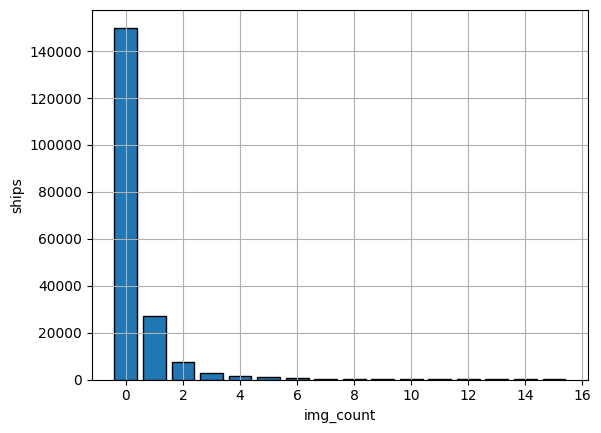

In [265]:

plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.grid(True)
plt.show()

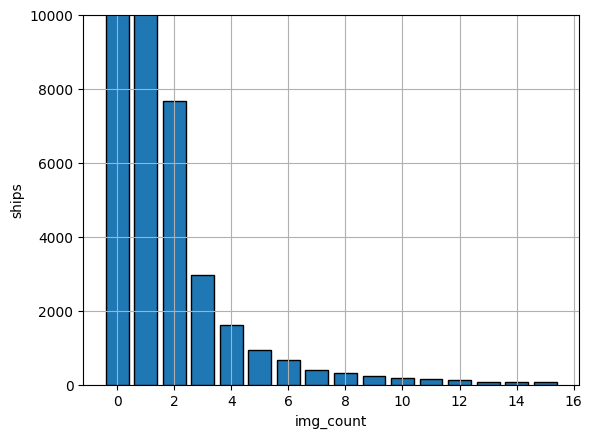

In [266]:

plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.ylim(0, 10_000)
plt.grid(True)
plt.show()

In [267]:
wout_ships = df[df['EncodedPixels'].isna()]
with_ships = df[df['EncodedPixels'].notna()]

reduced_wout_ships = wout_ships.sample(1500) 

balanced_df = pd.concat([with_ships, reduced_wout_ships])
balanced_df

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
73079,50f19f6e6.jpg,NaN
186043,cd86db555.jpg,NaN
225668,f95cfaa59.jpg,NaN
8598,095f0cca2.jpg,NaN


In [268]:
balanced_df['EncodedPixels'] = balanced_df['EncodedPixels'].astype(str)

In [269]:
balanced_grouped = balanced_df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).reset_index()
balanced_grouped

,ImageId,EncodedPixels
0,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...
1,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...
2,00021ddc3.jpg,[108287 1 109054 3 109821 4 110588 5 111356 5 ...
3,0002756f7.jpg,[255784 2 256552 4 257319 7 258087 9 258854 12...
4,00031f145.jpg,[340363 1 341129 4 341896 6 342663 7 343429 10...
...,...,...
44051,fff77c602.jpg,[133056 1 133823 4 134591 6 135358 8 136126 10...
44052,fff909871.jpg,[441057 2 441825 4 442592 7 443360 9 444128 11...
44053,fffcb6464.jpg,[222782 4 223550 10 224318 14 225086 14 225854...
44054,fffd924fb.jpg,[110011 5 110779 5 111547 5 112315 5 113083 5 ...


In [270]:
grouped = balanced_grouped.groupby(balanced_grouped['EncodedPixels'].apply(lambda x: x == ['nan']))

nan_group = grouped.filter(lambda x: x['EncodedPixels'].iloc[0] == ['nan'])
not_nan_group = grouped.filter(lambda x: x['EncodedPixels'].iloc[0] != ['nan'])

reduced_not_nan_group = not_nan_group.sample(5_000)

rebalanced_grouped = pd.concat([reduced_not_nan_group, nan_group])
rebalanced_grouped

,ImageId,EncodedPixels
32310,bc01989b8.jpg,[419969 1 420735 3 421501 6 422267 8 423033 11...
27856,a1aee968c.jpg,[48875 5 49635 13 50398 18 51166 18 51934 19 5...
19756,72acb4f98.jpg,[363199 1 363966 4 364734 5 365501 7 366268 7 ...
32548,bd8599ecf.jpg,[502118 7 502886 7 503654 7 504422 7 505190 7 ...
23993,8bc3bfe79.jpg,[538283 1 539050 4 539818 6 540585 8 541352 11...
...,...,...
43955,ff66b8219.jpg,[nan]
43969,ff79bcf7a.jpg,[nan]
43985,ff8c71c8d.jpg,[nan]
43986,ff9101773.jpg,[nan]


In [271]:
class ShipDataset(Dataset):
    def __init__(self, df, image_dir, image_shape=(768,768), transform=None, preprocessing_fn=None):
        self.df = df
        self.image_dir = image_dir
        self.shape = image_shape
        self.transform = transform
        self.preprocessing_fn = preprocessing_fn
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['ImageId']
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        rles = self.df.iloc[idx]['EncodedPixels']
        mask = self.combine_rle_masks(rles, self.shape)

        if self.transform:
            image = self.transform(image)
        if self.preprocessing_fn:
            image = self.preprocessing_fn(np.array(image))
        
        return image, mask
    

    def rle_to_mask(self, rle, shape):
        """
        converting RLE string into a mask.

        Parameters:
        rle (str): rle string (format "start1 length1 start2 length2 ...")
        shape (tuple): mask shape (height, width)

        Returns:
        numpy.ndarray: mask as 2D numpy array
        """

        mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

        if rle == 'nan':
            return mask.reshape(shape)

        rle_nums = list(map(int, rle.split()))

        starts = rle_nums[0::2]
        lengths = rle_nums[1::2]

        starts = [start -1  for start in starts]

        for start, length in zip(starts, lengths):
            mask[start:start + length] = 1

        return mask.reshape(shape).T

    def combine_rle_masks(self, rles, shape):
        """
        Combines several RLE masks into one.

        Parameters:
        rles (list of str): list of rle strings
        shape (tuple): mask shape (height, width)

        Returns:
        torch.Tensor: combined mask as a 2D tensor
        """
        combined_mask = np.zeros(shape, dtype=np.uint8)

        for rle in rles:
            mask = self.rle_to_mask(rle, shape)
            combined_mask = np.maximum(combined_mask, mask)
            
        tensor_combined_mask = torch.tensor(combined_mask, dtype=torch.uint8)

        return tensor_combined_mask
    
   

In [272]:
visualize_dataset =  ShipDataset(df=rebalanced_grouped, image_dir=img_dir)

In [273]:
unique_image_ids = rebalanced_grouped['ImageId'].unique()

In [274]:
train_ids, test_ids = train_test_split(unique_image_ids, train_size=0.8, random_state=42)

train_df = rebalanced_grouped[rebalanced_grouped['ImageId'].isin(train_ids)]
test_df = rebalanced_grouped[rebalanced_grouped['ImageId'].isin(test_ids)]

train_grouped = train_df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).reset_index()
test_grouped = test_df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).reset_index()

train_grouped.columns = ['ImageId', 'EncodedPixels']
test_grouped.columns = ['ImageId', 'EncodedPixels']

In [275]:
train_grouped['EncodedPixels'].iloc[1]

[['70386 1 71152 4 71918 6 72685 8 73451 10 74218 12 74984 15 75750 17 76517 19 77283 21 78050 23 78816 26 79582 28 80349 30 81115 32 81882 34 82651 34 83419 34 84188 34 84956 34 85725 34 86494 34 87262 34 88031 34 88799 34 89568 34 90337 34 91105 34 91874 34 92642 34 93411 34 94180 34 94948 34 95717 34 96485 34 97254 34 98023 34 98791 34 99560 34 100328 34 101097 34 101866 34 102634 34 103403 34 104171 35 104940 34 105708 35 106477 34 107246 34 108014 35 108783 34 109551 35 110320 34 111089 34 111857 35 112626 34 113394 35 114163 34 114932 34 115700 35 116469 34 117237 35 118006 34 118775 34 119543 35 120312 34 121080 35 121849 34 122618 34 123386 35 124155 34 124923 35 125692 34 126461 34 127229 35 127998 34 128766 35 129535 34 130304 34 131072 35 131841 34 132609 35 133378 34 134147 34 134915 35 135684 34 136452 35 137221 34 137990 34 138758 35 139527 34 140295 35 141064 34 141833 34 142601 35 143370 34 144138 35 144907 34 145675 35 146444 35 147213 34 147981 35 148750 34 149518 35 

In [276]:
preprocess = get_preprocessing_fn('resnet34', pretrained='imagenet')

train_dataset = ShipDataset(df=train_grouped, image_dir=img_dir, preprocessing_fn=preprocess)
test_dataset = ShipDataset(df=test_grouped, image_dir=img_dir, preprocessing_fn=preprocess)


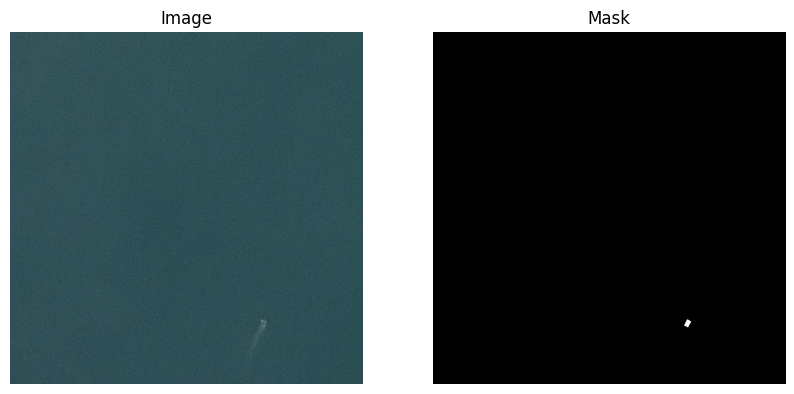

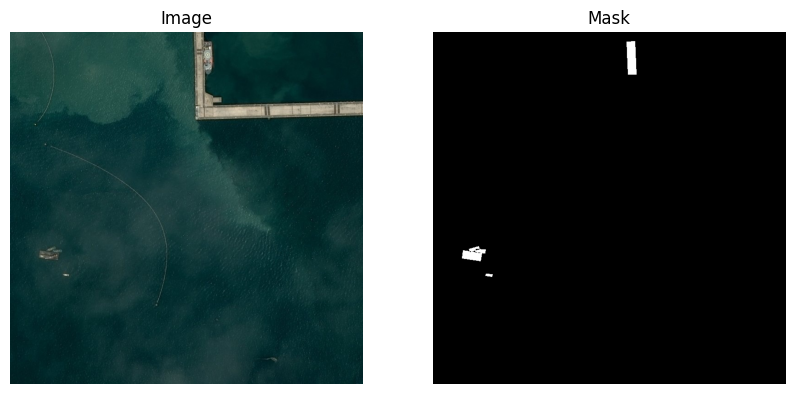

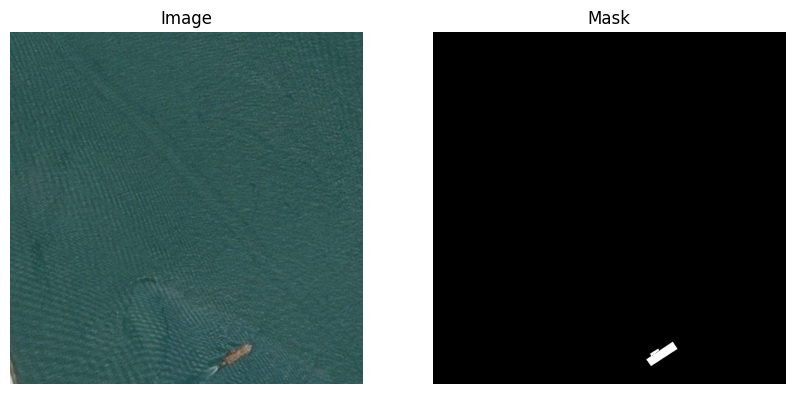

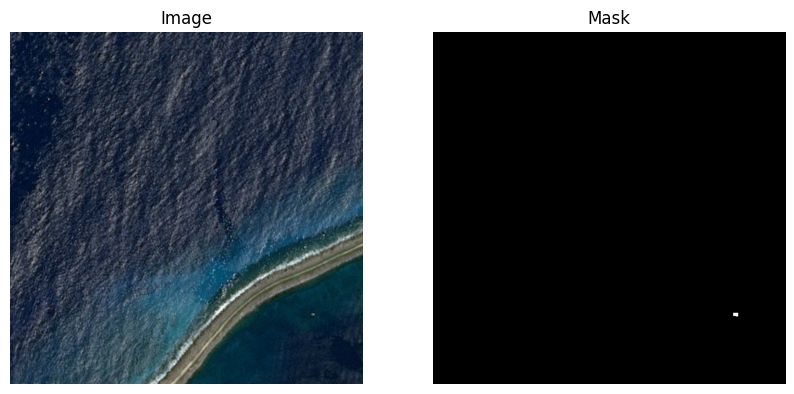

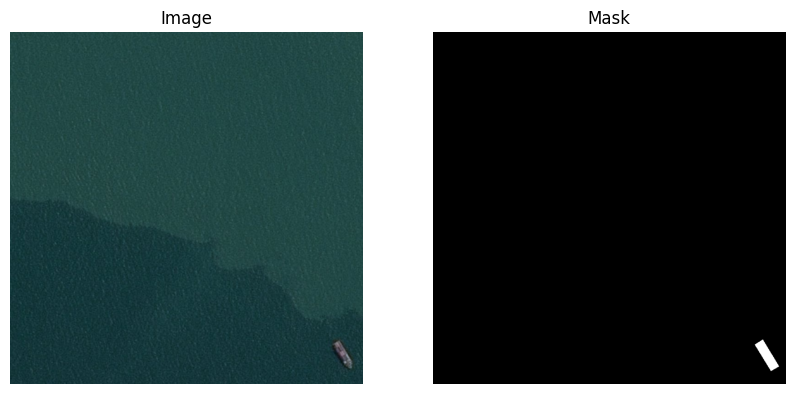

In [277]:
for i in range(5):
    image, mask = visualize_dataset[i]
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()

    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 2, 1)  
    plt.imshow(image)  
    plt.title("Image")  
    plt.axis("off")  
    
    plt.subplot(1, 2, 2)  
    plt.imshow(mask, cmap='gray')  
    plt.title("Mask")  
    plt.axis("off")  
    plt.show()  

In [281]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [282]:
model = DeepLabV3Plus(encoder_name='resnet34', 
                      encoder_depth=5, 
                      encoder_weights='imagenet', 
                      encoder_output_stride=16, 
                      decoder_channels=256, 
                      decoder_atrous_rates=(12, 24, 36), 
                      in_channels=3, 
                      classes=1, 
                      activation='sigmoid', 
                      upsampling=4)

model = model.to(device)

for param in model.encoder.parameters():
    param.requires_grad = False

In [283]:
summary(model, input_size=(3, 768, 768))

OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 65.06 MiB is free. Process 3208 has 14.68 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 7.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# @title train function
import time

def train_segmentation(model, optimizer, loss_fn, train_dl, val_dl, epochs=20, device='cpu'):
    """
    Trains a segmentation model using Dice Loss and Recall as the evaluation metric.
    
    Parameters
    ----------
    model : nn.Module
        The segmentation model to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : nn.Module
        The loss function to use for training (DiceLoss).
    train_dl : DataLoader
        DataLoader for the training dataset.
    val_dl : DataLoader
        DataLoader for the validation dataset.
    epochs : int, optional
        Number of epochs to train the model. Default is 20.
    device : str, optional
        The device to use for training ('cpu' or 'cuda'). Default is 'cpu'.
    
    Returns
    -------
    dict
        Dictionary containing training and validation loss and recall for each epoch.
    """
    
    recall = torchmetrics.Recall(num_classes=1, threshold=0.5, task='binary').to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_recall': [],
        'val_recall': []
    }

    model.to(device)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_recall = 0.0
        
        for batch in train_dl:
            images, masks = batch
            images, masks = images.permute(0, 3, 1, 2).to(torch.float32).to(device), masks.to(device)
            masks = masks.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_recall += recall(outputs, masks.int()).item() * images.size(0)
        
        train_loss /= len(train_dl.dataset)
        train_recall /= len(train_dl.dataset)
        
        model.eval()
        val_loss = 0.0
        val_recall = 0.0
        
        with torch.no_grad():
            for batch in val_dl:
                images, masks = batch
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_recall += recall(outputs, masks.int()).item() * images.size(0)
        
        val_loss /= len(val_dl.dataset)
        val_recall /= len(val_dl.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Recall: {train_recall:.4f}, Val Recall: {val_recall:.4f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} sec")

    return history

In [ ]:
loss_fn = DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
history = train_segmentation(model, optimizer, loss_fn, train_loader, test_loader, epochs=20, device=device)

In [ ]:
def plot_metric(history, name):

    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.title(f'{name.capitalize()} over Epochs')
    plt.legend()
    plt.show()


In [ ]:
plot_metric(history, 'loss')

In [ ]:
plot_metric(history, 'recall')

In [ ]:
torch.save(model, 'ship_segmentation_model.pth')